In [183]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from barnacle.tensors import SparseCPTensor
from matplotlib import pyplot as plt
from pathlib import Path
from tlviz.factor_tools import factor_match_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import precision_score
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# import data

In [4]:
# read in aligned model datasets

datapath = Path('../../data/5-models/')

pro_ds = xr.open_dataset(datapath / 'pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / 'syn-aligned-models.nc')

pro_ds

<xarray.Dataset>
Dimensions:           (bootstrap: 100, replicate: 3, component: 20,
                       ortholog: 5084, clade: 3, samplename: 76)
Coordinates:
  * bootstrap         (bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * replicate         (replicate) object 'A' 'B' 'C'
  * component         (component) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20
  * ortholog          (ortholog) int64 60000001 60000002 ... 60040287 60040292
  * clade             (clade) object 'HLI' 'HLII' 'LLI'
  * samplename        (samplename) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.N...
Data variables:
    componentweights  (bootstrap, replicate, component) float64 ...
    geneweights       (bootstrap, replicate, component, ortholog) float64 ...
    taxonweights      (bootstrap, replicate, component, clade) float64 ...
    sampleweights     (bootstrap, replicate, component, samplename) float64 ...
    sample            (bootstrap, replicate, samplename) object ...

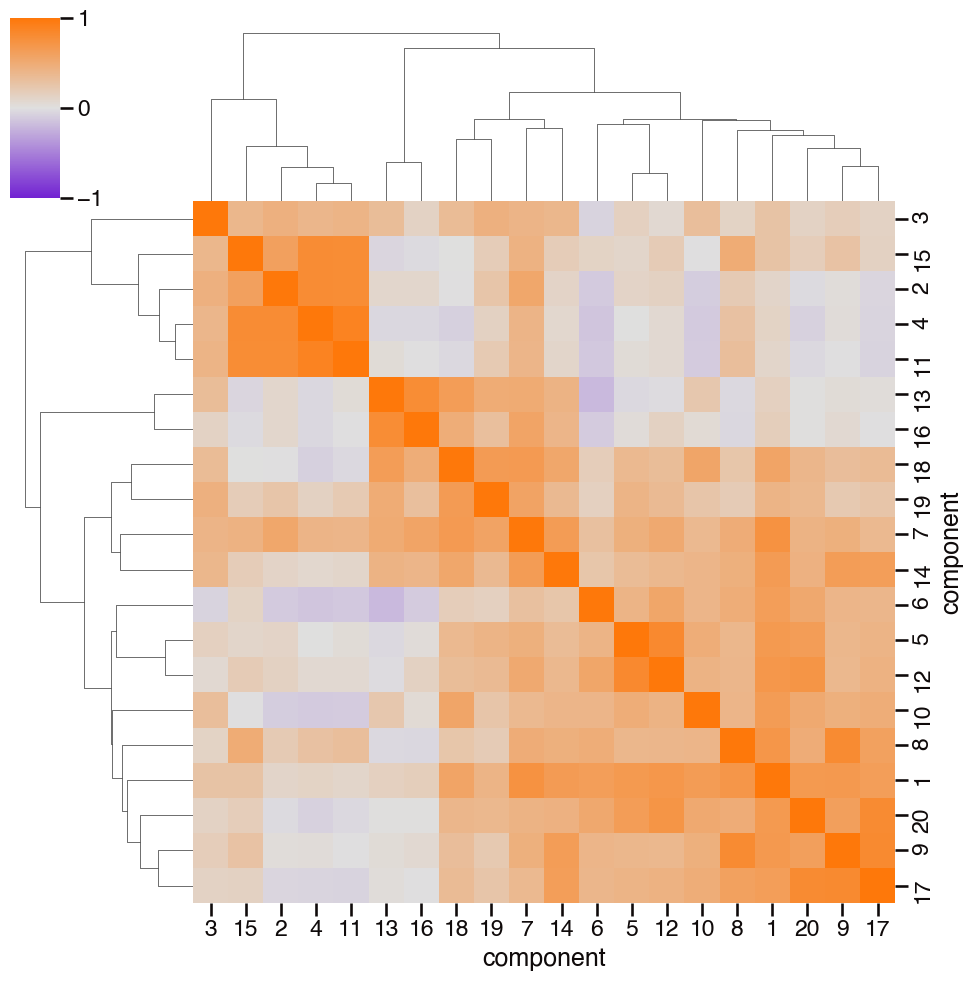

In [30]:
# assemble averaged weight profiles for each mode

cyano = 'pro'

med_ds = pro_ds.median(dim=['bootstrap', 'replicate'])

weights_df = pd.concat([
#     med_ds.geneweights.T.to_pandas(), 
    med_ds.taxonweights.T.to_pandas(), 
    med_ds.sampleweights.T.to_pandas()]
)

# generate correlation matrix
corr_df = weights_df.corr()

# generate upper triangle mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.clustermap(
    corr_df, 
#     mask=mask, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}
)


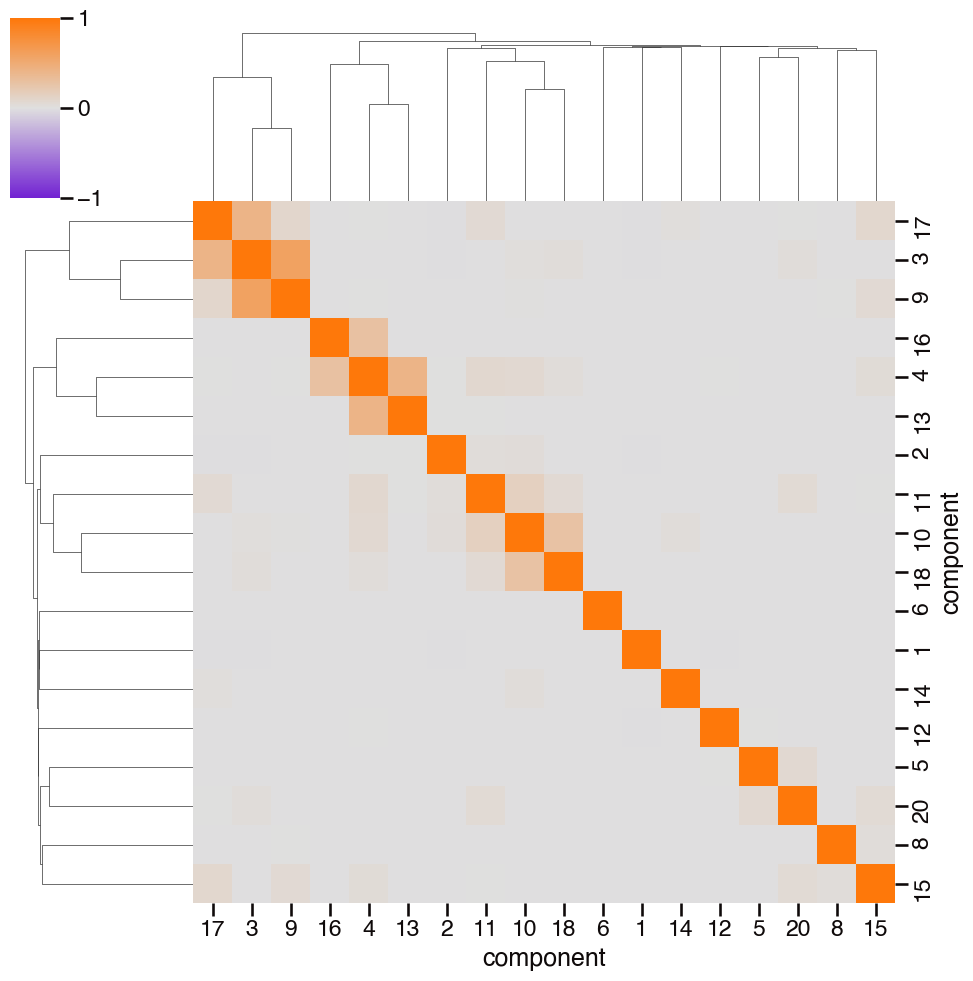

In [28]:
# pro gene weights

weights_df = pro_ds.median(dim=['bootstrap', 'replicate']).geneweights.T.to_pandas()

# drop zeroed-out components
weights_df = weights_df.loc[:, ~weights_df.eq(0).all(axis=0)]

# generate correlation matrix
corr_df = weights_df.corr()

# generate upper triangle mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.clustermap(
    corr_df, 
#     mask=mask, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}
)


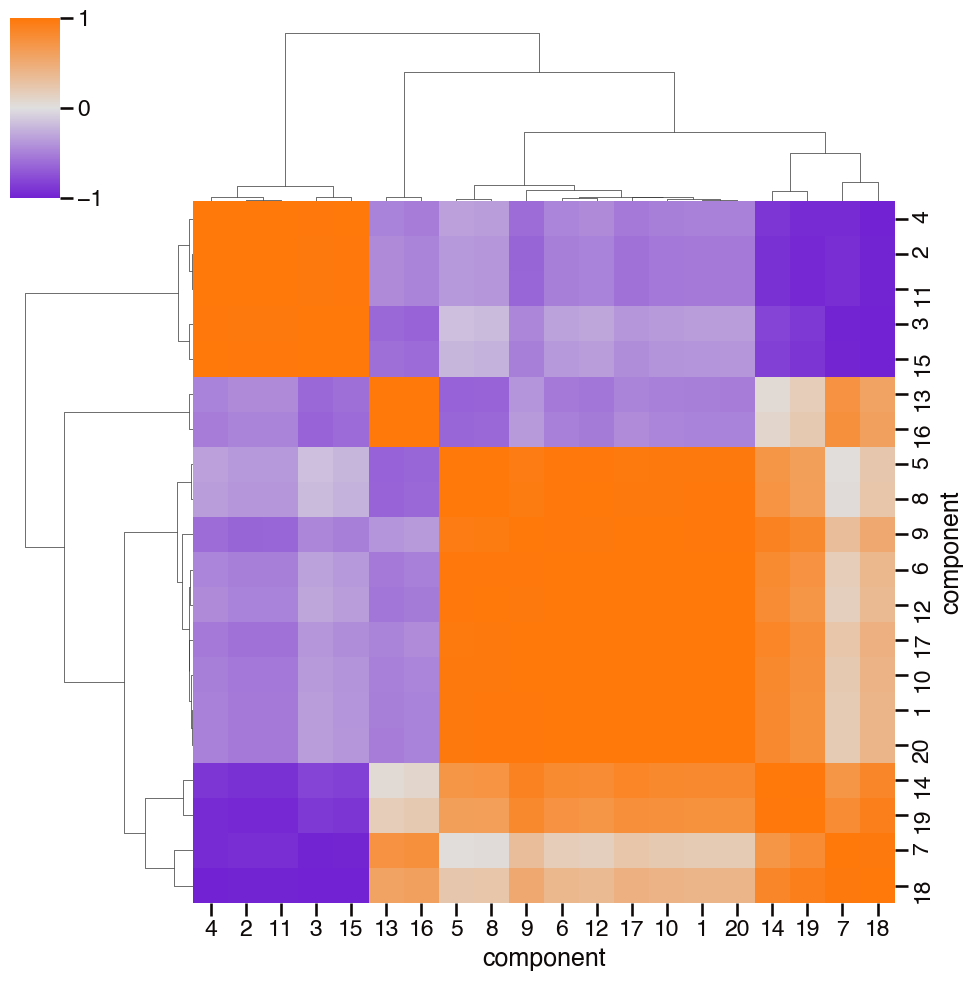

In [31]:
# pro taxon weights

weights_df = pro_ds.median(dim=['bootstrap', 'replicate']).taxonweights.T.to_pandas()

# generate correlation matrix
corr_df = weights_df.corr()

# generate upper triangle mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.clustermap(corr_df, cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5})


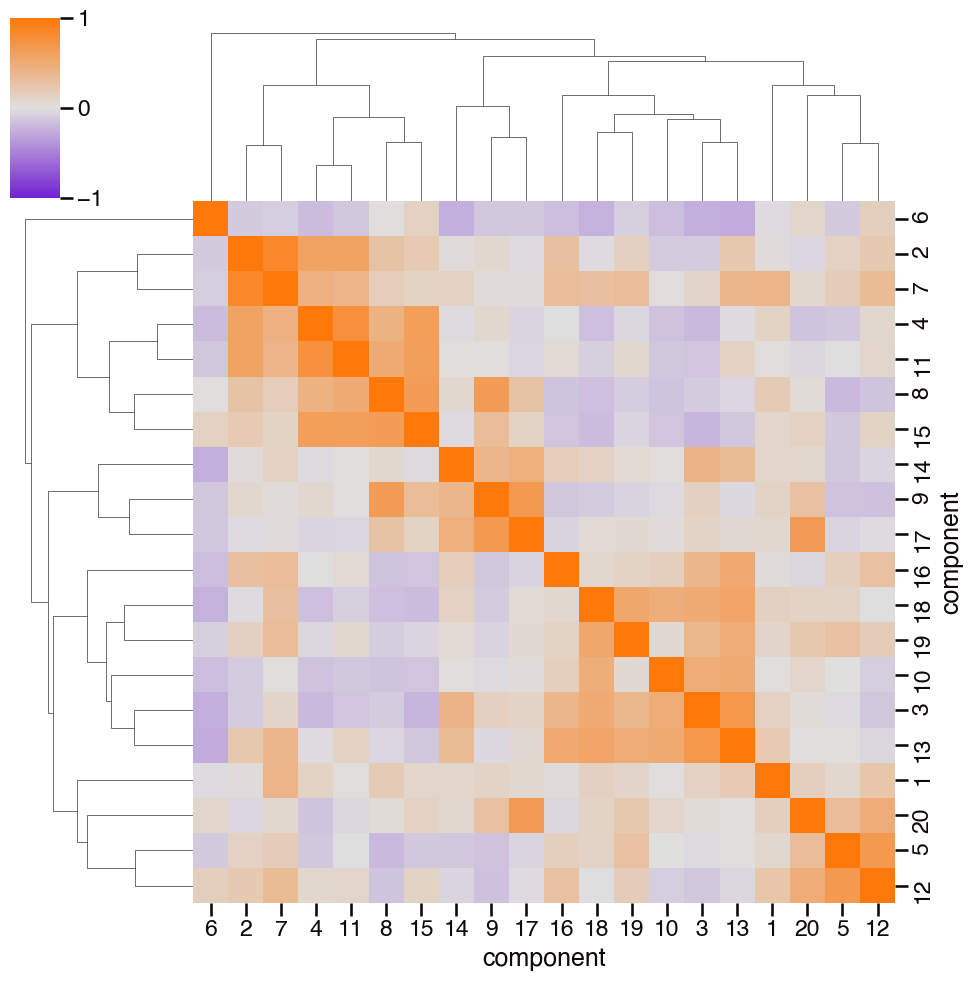

In [33]:
# pro sample weights

weights_df = pro_ds.median(dim=['bootstrap', 'replicate']).sampleweights.T.to_pandas()

# generate correlation matrix
corr_df = weights_df.corr()

# generate upper triangle mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.clustermap(corr_df, cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5})


# Ideas:

- Look at this with FMS
- Look at DICE score?
    - Especially for genes
    

# DICE scores

/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


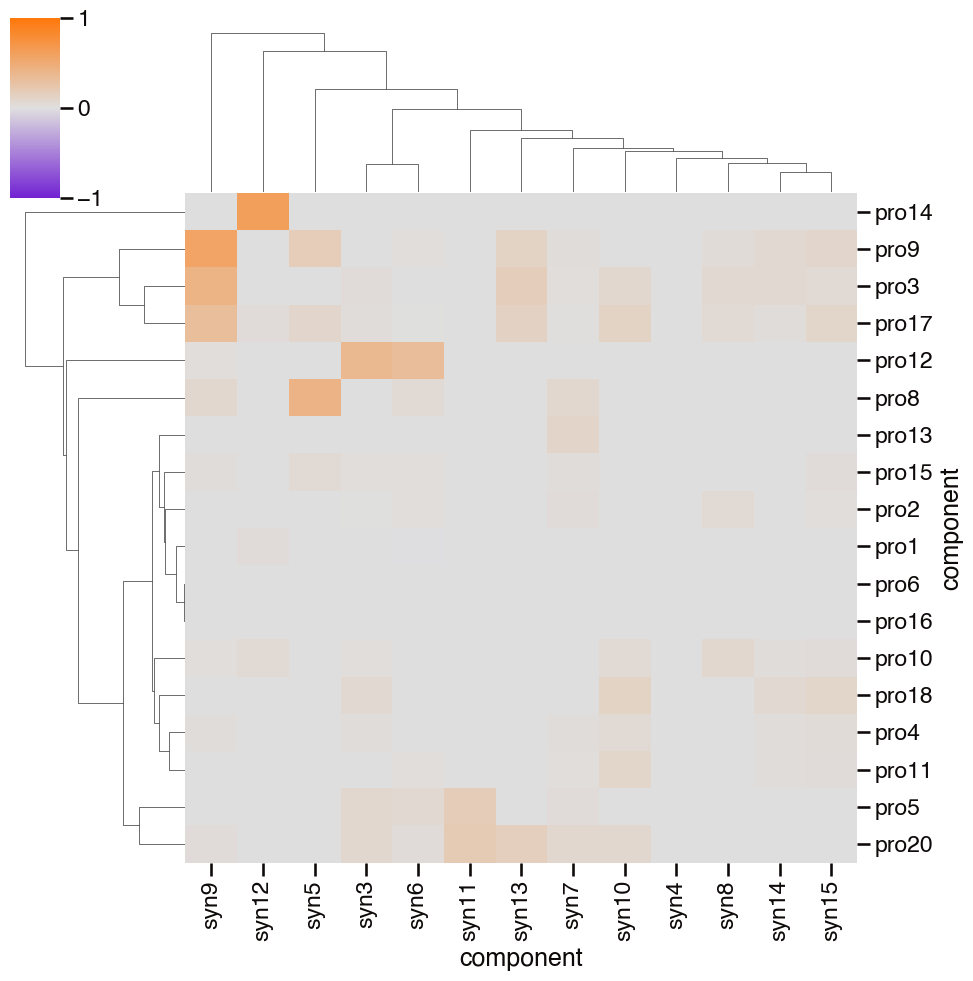

In [147]:
# assemble dataframe of gene cluster members from both pro & syn models

# pro gene weights at 50% bootstrap cutoff (median)
pro_geneweights_df = pro_ds.median(dim=['bootstrap', 'replicate']).geneweights.T.to_pandas()
pro_geneweights_df = pro_geneweights_df.rename(
    columns=dict(zip(pro_geneweights_df.columns, [f'pro{i}' for i in pro_geneweights_df.columns])))

# syn gene weights at 50% bootstrap cutoff (median)
syn_geneweights_df = syn_ds.median(dim=['bootstrap', 'replicate']).geneweights.T.to_pandas()
syn_geneweights_df = syn_geneweights_df.rename(
    columns=dict(zip(syn_geneweights_df.columns, [f'syn{i}' for i in syn_geneweights_df.columns])))

# merge into one dataframe
gene_clusters_df = pd.merge(
    pro_geneweights_df, syn_geneweights_df, left_index=True, right_index=True, how='outer').fillna(0)

# binary support for gene membership
gene_clusters_df = ~gene_clusters_df.eq(0)

# drop zeroed-out components
gene_clusters_df = gene_clusters_df.loc[:, ~gene_clusters_df.eq(0).all(axis=0)]

# # make precision matrix
# precision_df = pd.DataFrame(index=gene_clusters_df.columns, columns=gene_clusters_df.columns, dtype=float)
# for ref_name, ref_col in gene_clusters_df.items():
#     for comp_name, comp_col in gene_clusters_df.items():
#         precision_df.loc[ref_name, comp_name] = precision_score(ref_col, comp_col)

# make heatmap
# sns.heatmap(precision_df, cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, square=True)
sns.clustermap(
#     gene_clusters_df.loc[:, 'syn3': 'syn15'].corr(), 
#     gene_clusters_df.loc[:, 'pro1': 'pro20'].corr(), 
    gene_clusters_df.corr().loc['pro1': 'pro20', 'syn3': 'syn15'], 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, square=True
)


In [187]:
gene_clusters_df

component,pro1,pro2,pro3,pro4,pro5,pro6,pro8,pro9,pro10,pro11,...,syn6,syn7,syn8,syn9,syn10,syn11,syn12,syn13,syn14,syn15
ortholog,,,,,,,,,,,,,,,,,,,,,
60000001,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
60000002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
60000003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
60000004,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
60000005,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60040245,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
60040246,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
60040262,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Factor Match Score

<Axes: >

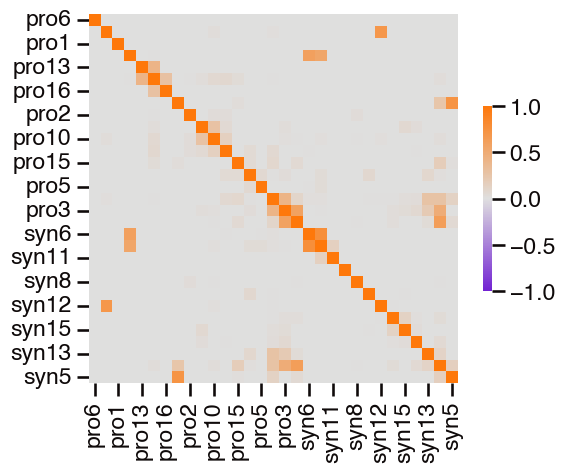

In [219]:
# assemble dataframe of gene cluster members from both pro & syn models

# make joint gene weights df
joint_geneweights_df = pd.merge(
    pro_geneweights_df, syn_geneweights_df, left_index=True, right_index=True, how='outer').fillna(0)

# make SparseCP tensor from bootstrap medians
pro_med_ds = pro_ds.median(dim=['bootstrap', 'replicate'])
syn_med_ds = syn_ds.median(dim=['bootstrap', 'replicate'])

# generate pro & syn cluster labels
pro_labels = [f'pro{c}' for c in pro_med_ds.component.data]
syn_labels = [f'syn{c}' for c in syn_med_ds.component.data]
combined_labels = pro_labels + syn_labels

# make matrix of cosine similarity scores between gene weights
css_genes_df = pd.DataFrame(
    cosine_similarity(joint_geneweights_df.T, joint_geneweights_df.T), 
    index=combined_labels, 
    columns=combined_labels
)

# drop zeroed-out components
css_genes_df = css_genes_df.loc[:, ~css_genes_df.eq(0).all(axis=0)]
pro_labels = [label for label in pro_labels if label in css_genes_df.columns]
syn_labels = [label for label in syn_labels if label in css_genes_df.columns]

# cluster the pro portion
linkage = hierarchy.linkage(css_genes_df.loc[pro_labels, pro_labels], optimal_ordering=True)
dendrogram = hierarchy.dendrogram(linkage, no_plot=True)
# rearrange pro labels based on dendrogram
pro_labels = [pro_labels[i] for i in dendrogram['leaves']]

# cluster the syn portion
linkage = hierarchy.linkage(css_genes_df.loc[syn_labels, syn_labels], optimal_ordering=True)
dendrogram = hierarchy.dendrogram(linkage, no_plot=True)
# rearrange labels 
syn_labels = [syn_labels[i] for i in dendrogram['leaves']]

# make heatmap
sns.heatmap(
    css_genes_df.loc[pro_labels+syn_labels, pro_labels+syn_labels],  
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, square=True
)


In [206]:
model.labels_

array([12,  7, 11, 10,  8,  6,  3,  5,  9,  2,  4,  1,  0])

In [188]:
# make joint gene weights df
joint_geneweights_df = pd.merge(
    pro_geneweights_df, syn_geneweights_df, left_index=True, right_index=True, how='outer').fillna(0)

In [215]:
from scipy.cluster import hierarchy

In [168]:
hierarchy.linkage(css_genes_df.loc[syn_labels, syn_labels], )

In [185]:
cosine_similarity(pro_med_ds.geneweights, pro_med_ds.geneweights)

(20, 20)

In [166]:
SparseCP(cp)

TypeError: SparseCP.__init__() missing 1 required positional argument: 'lambdas'

[13, 9, 17, 6, 1, 12, 10, 14, 16, 3, 5, 0, 4, 2, 7, 8, 15, 11]

In [213]:
pro_labels

['pro11',
 'pro13',
 'pro20',
 'pro18',
 'pro15',
 'pro10',
 'pro12',
 'pro5',
 'pro17',
 'pro14',
 'pro16',
 'pro9',
 'pro4',
 'pro6',
 'pro8',
 'pro3',
 'pro2',
 'pro1']

In [152]:
model.labels_

array([14,  8, 11,  9,  7, 10,  4, 13, 12,  3,  5,  6,  2,  1,  0])

# TODO

- cluster pro & syn individually by jaccard
- sort precision matrix by cluster order
- plot each quadrant separately

- do it for both correlation (FMS) and precision

- do all this again with clusters from Zinser et al paper


# Junk Yard

In [196]:
# junk yard
pro_cp = SparseCPTensor(
    (
        pro_med_ds.componentweights.data, 
        [
            joint_geneweights_df.loc[:, pro_labels].to_numpy(), 
            pro_med_ds.taxonweights.data.T, 
            pro_med_ds.sampleweights.data.T
        ]
    )
)
syn_cp = SparseCPTensor(
    (
        syn_med_ds.componentweights.data, 
        [
            joint_geneweights_df.loc[:, syn_labels].to_numpy(), 
            syn_med_ds.taxonweights.data.T, 
            syn_med_ds.sampleweights.data.T
        ]
    )
)